# Brent Oil Prices Modelo 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [ ]:
Brent_Oil_Prices=pd.read_csv('BrentOilPrices.csv')

Brent_Oil_Prices['Date']=pd.to_datetime(Brent_Oil_Prices['Date'])

Brent_prices = Brent_Oil_Prices.set_index('Date')

Brent_prices.index = pd.to_datetime(Brent_prices.index).normalize()

full_range = pd.date_range(start=Brent_prices.index.min(),
                           end=Brent_prices.index.max(),
                           freq='D')

/tmp/ipykernel_71643/3628053063.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Brent_Oil_Prices['Date']=pd.to_datetime(Brent_Oil_Prices['Date'])


In [ ]:
Brent_prices_full = Brent_prices.reindex(full_range)
Brent_prices_full.index.name = 'Date'

Brent_prices_full

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,NaN
1987-05-24,NaN
...,...
2022-11-10,94.25
2022-11-11,96.37
2022-11-12,NaN


In [ ]:
Brent_prices_imputed = Brent_prices_full.interpolate(method='time')
Brent_prices_imputed

,Price
Date,
1987-05-20,18.630000
1987-05-21,18.450000
1987-05-22,18.550000
1987-05-23,18.566667
1987-05-24,18.583333
...,...
2022-11-10,94.250000
2022-11-11,96.370000
2022-11-12,95.443333


Epoch 1/20


W0000 00:00:1764389011.720320   71643 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.9116e-04 - val_loss: 8.8516e-04
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.5097e-04 - val_loss: 2.8680e-04
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.4716e-04 - val_loss: 4.4376e-04
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.2201e-04 - val_loss: 2.4963e-04
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.1678e-04 - val_loss: 2.2730e-04
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0695e-04 - val_loss: 2.5199e-04
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0205e-04 - val_loss: 2.7475e-04
Epoch 9/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.5516e-05 - val_loss: 2.8642e-04
Epoch 10/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.5737e-05 - val_loss: 1.6094e-04
Epoch 11/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.3624e

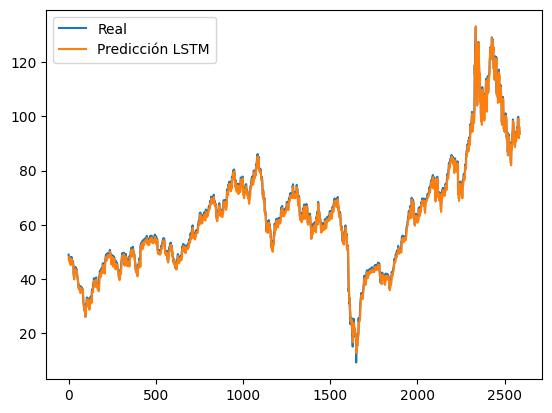

In [ ]:
df = Brent_prices_imputed.copy()
df.index = pd.to_datetime(df.index)

# Escalado
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Price']])

# Crear secuencias
window = 30  # usar 30 días para predecir el siguiente
X, y = [], []
for i in range(window, len(scaled)):
    X.append(scaled[i-window:i])
    y.append(scaled[i])

X = np.array(X)
y = np.array(y)

# Train-test split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window,1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Predicciones
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)
real = scaler.inverse_transform(y_test)

plt.plot(real, label='Real')
plt.plot(pred, label='Predicción LSTM')
plt.legend()
plt.show()


In [ ]:
# Predicciones y valores reales 
pred = scaler.inverse_transform(model.predict(X_test))
real = scaler.inverse_transform(y_test)

# Métricas
rmse = np.sqrt(mean_squared_error(real, pred))
mae = mean_absolute_error(real, pred)
mape = np.mean(np.abs((real - pred) / real)) * 100
r2 = r2_score(real, pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 score: {r2:.4f}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 1.5025
MAE: 1.0999
MAPE: 1.90%
R2 score: 0.9947
